# Week 3 Homework

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rethinking))
suppressPackageStartupMessages(library(ggdag))
suppressPackageStartupMessages(library(dagitty))

theme_dag_dracula = function() {
    theme(
      plot.background = element_rect("#282A36"),
      panel.background = element_rect("#282A36"),
      panel.grid = element_blank(),
      axis.title = element_blank(),
      axis.text = element_blank(),
      axis.ticks = element_blank(),
    )
}

data(foxes)

foxes_data = foxes %>% as_tibble()


Warning messages:
1: package ‘cmdstanr’ was built under R version 4.3.3 
2: package ‘posterior’ was built under R version 4.3.3 
Warning message:
package ‘ggdag’ was built under R version 4.3.3 


## DAG For Problems

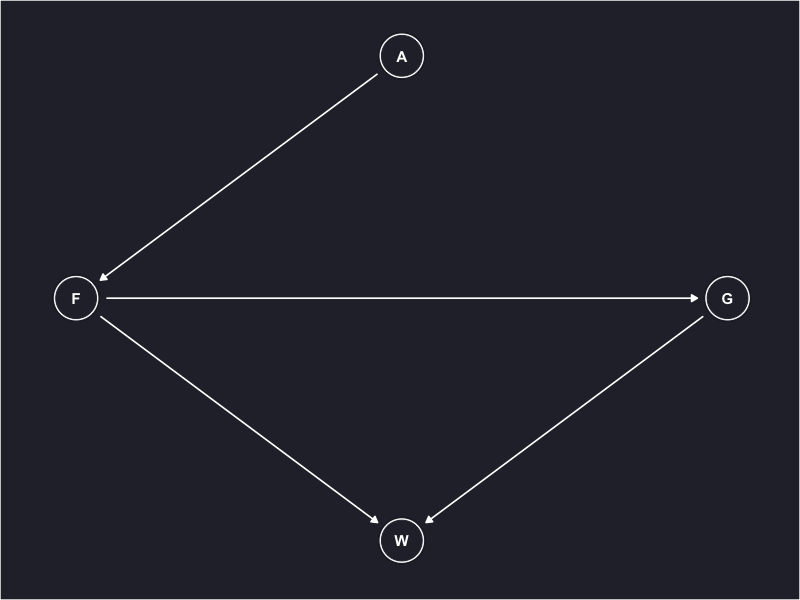

In [2]:
fox_dag = ggdag::dagify(
  F ~ A,
  G ~ F,
  W ~ G,
  W ~ F,
  exposure = "A",
  outcome = "F",
  coords = list(
    x = c(A = 0, F = -1, G = 1, W = 0),
    y = c(A = 1, F = 0, G = 0, W = -1)
  )
) 

ggdag(fox_dag) +
  geom_dag_edges(edge_colour = "#ffffff") +
  geom_dag_node(colour = "#282A36") +
  geom_dag_text(colour = "#ffffff") + 
  theme_dag_dracula()

## Question 1
**Use the backdoor criterion and estimate the total causal influence of A on F. What effect would increasing the area of a territory have on the amount of food inside it?**

Since there is no arrows going into A, we don't need to wory about the backdoor effect. Lets state some assumptions about how A affects F.
- Larger Area = More Area for Food
- 0 Area = 0 Food
- Area > 0

Lets say Area and Food have a linear relationship. We can show this in the following model:

$$
\begin{align}
F_i &\sim \text{Normal}(\mu_i, \sigma)\\
\mu_i &= \alpha + \beta A_i \\
\alpha &\sim \text{Normal}(0, 10) \\
\beta &\sim \text{Uniform}(0, 2) \\
\sigma &\sim \text{Exponential}(1)
\end{align}
$$

Now lets use our data to determine the correlation

In [5]:
af_model = quap(
  alist(
    F ~ dnorm(mu, sigma),
    mu <- a + bA * A,
    a ~ dnorm(0, 10),
    bA ~ dunif(0, 2),
    sigma ~ dexp(1)
  ),
  data = list(F = standardize(foxes_data$avgfood), A = standardize(foxes_data$area))
)

precis(af_model)

      mean   sd  5.5% 94.5%
a     0.00 0.04 -0.07  0.07
bA    0.88 0.04  0.81  0.95
sigma 0.47 0.03  0.42  0.51

This shows that there is a significant correlation between area and food. As we increase the area by 1 SD, we get an approximate 0.8 increase in food.

## Question 2
**Infer the total causal effect of adding food F to a territory on the weight W of foxes. Can you calculate the causal effect by simulating an intervention on food?**

To undestand the Total Causal Effect on F on W, we can simply do a model on F -> W

In [14]:
fw_model = quap(
  alist(
    W ~ dnorm( mu , sigma ),
    mu <- a + bF*F,
    a ~ dnorm(0,0.2),
    bF ~ dnorm(0,0.5),
    sigma ~ dexp(1)
  ), 
  data=list(F = standardize(foxes_data$avgfood), W = standardize(foxes_data$weight))
)

precis(fw_model)

       mean   sd  5.5% 94.5%
a      0.00 0.08 -0.13  0.13
bF    -0.02 0.09 -0.17  0.12
sigma  0.99 0.06  0.89  1.09